In [40]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

import numpy as np

import seaborn as sns
sns.set(style='whitegrid')

import pandas as pd
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import dask.dataframe as dd 

StatementMeta(Spark11, 7, 40, Finished, Available)

In [79]:
# The file is located in the Azure Data Lake Storage and needs to be converted from the PySpark Dataframe to Pandas Dataframe.

df = dd.read_csv('***/Lending_club_loan_data.csv', dtype={'desc': 'object', 'id':'object', 'sec_app_earliest_cr_line':'object'}, low_memory=False)
data = df.compute() 

# we'll make copy of the data, in case we need it in the future
data_copy = df.compute()

StatementMeta(Spark11, 7, 79, Finished, Available)

In [80]:
data.head()

StatementMeta(Spark11, 7, 80, Finished, Available)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade                    emp_title  \
0     13.99       123.03     C        C4                      leadman   
1     11.99       820.28     C        C1                     Engineer   
2     10.78       432.66     B        B4                 truck driver   
3     14.85       829.90     C        C5  Information Systems Officer   
4     22.45       289.91     F        F1          Contract Specialist   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0  10+ years       MORTGAGE     55000.0        Not Verified  Dec-2015   
1  10+ years       MORTGAGE     65000.0        Not Verified  Dec-2015   
2  10+ years       MORTGAGE     63000.0        Not Verified  Dec-2015   
3  10+ years       MORTGAGE    110000.0     Source Verified  Dec-2015   
4    3 years       MORTGAGE    104433.0     Source Verified  Dec-2015   

  loan_status pymnt_plan  \
0  Fully Paid          n   
1  Fully Paid          n   
2  Fully Paid          n   
3     Current          n   
4  Fully Paid          n   

                                                                 url desc  \
0  https://lendingclub.com/browse/loanDetail.action?loan_id=68407277  NaN   
1  https://lendingclub.com/browse/loanDetail.action?loan_id=68355089  NaN   
2  https://lendingclub.com/browse/loanDetail.action?loan_id=68341763  NaN   
3  https://lendingclub.com/browse/loanDetail.action?loan_id=66310712  NaN   
4  https://lendingclub.com/browse/loanDetail.action?loan_id=68476807  NaN   

              purpose               title zip_code addr_state    dti  \
0  debt_consolidation  Debt consolidation    190xx         PA   5.91   
1      small_business            Business    577xx         SD  16.06   
2    home_improvement                 NaN    605xx         IL  10.78   
3  debt_consolidation  Debt consolidation    076xx         NJ  17.06   
4      major_purchase      Major purchase    174xx         PA  25.37   

   delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0          0.0         Aug-2003           675.0            679.0   
1          1.0         Dec-1999           715.0            719.0   
2          0.0         Aug-2000           695.0            699.0   
3          0.0         Sep-2008           785.0            789.0   
4          1.0         Jun-1998           695.0            699.0   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0             1.0                    30.0                     NaN       7.0   
1             4.0                     6.0                     NaN      22.0   
2             0.0                     NaN                     NaN       6.0   
3             0.0                     NaN                     NaN      13.0   
4             3.0                    12.0                     NaN      12.0   

   pub_rec  revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0      0.0     2765.0        29.7       13.0                   w       0.00   
1      0.0    21470.0        19.2       38.0                   w       0.00   
2      0.0     7869.0        56.2       18.0                   w       0.00   
3      0.0     7802.0        11.6       17.0                   w   15897.65   
4      0.0    21929.0        64.5       35.0                   w       0.00   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0           0.00   4421.723917          4421.72          3600.00   
1           0.00  25679.660000         25679.66         24700.00   
2           0.00  22705.9242

In [81]:
data.shape

StatementMeta(Spark11, 7, 81, Finished, Available)

(2260701, 151)

In [82]:
# let's check how many columns have more than 50% or more missing data

data.isnull().sum()

StatementMeta(Spark11, 7, 82, Finished, Available)

id                                                  0
member_id                                     2260701
loan_amnt                                          33
funded_amnt                                        33
funded_amnt_inv                                    33
term                                               33
int_rate                                           33
installment                                        33
grade                                              33
sub_grade                                          33
emp_title                                      167002
emp_length                                     146940
home_ownership                                     33
annual_inc                                         37
verification_status                                33
issue_d                                            33
loan_status                                        33
pymnt_plan                                         33
url                         

In [83]:
# we will drop those columns, since it can be very difficult to fill in values for so many missing rows
# another thing is that there are 151 feature, and the goal is to reduce that number as much as possible
# we need to make sure that we don't write off valuable data

keep_columns = data.columns[((data.isnull().sum()/len(data))*100 < 50)].to_list()
data = data[keep_columns]

StatementMeta(Spark11, 7, 83, Finished, Available)

In [84]:
def frequency_histogram(plot_data, type):
    count_classes = data.value_counts(plot_data, sort = True).sort_index()
    count_classes.plot(kind = 'bar')
    plt.xlabel(type)
    plt.ylabel("Frequency")
    plt.show()

StatementMeta(Spark11, 7, 84, Finished, Available)

In [85]:
def return_heatmap():
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='viridis')
    plt.show()

StatementMeta(Spark11, 7, 85, Finished, Available)

In [86]:
d_missing = ((data.isnull().sum()/len(data))*100)[((data.isnull().sum()/len(data))*100) > 0]

StatementMeta(Spark11, 7, 86, Finished, Available)

In [87]:
def missing_values(feature):
    if feature in d_missing:
        return(f"% of missing values = {d_missing[feature].round(2)}")
    else:
        return("No missing values")

StatementMeta(Spark11, 7, 87, Finished, Available)

StatementMeta(Spark11, 7, 88, Finished, Available)

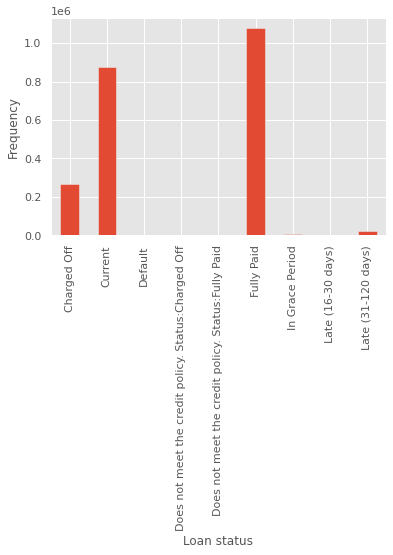

In [88]:
# the class lable in this case is loan_status

frequency_histogram(data['loan_status'], 'Loan status')

In [89]:
# for our further analysis, we will only keep the Fully Paid and Charged Off values and convert them into 0(Fully Paid) and 1(Charged Off)

data = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]
data.loan_status.replace(('Fully Paid', 'Charged Off'), (0, 1), inplace=True) 

StatementMeta(Spark11, 7, 89, Finished, Available)

StatementMeta(Spark11, 7, 90, Finished, Available)

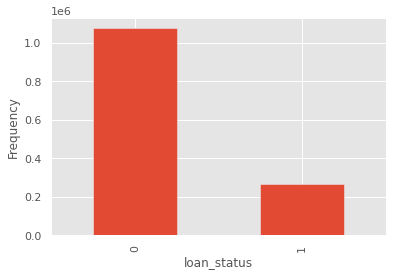

In [90]:
frequency_histogram(data['loan_status'], 'loan_status')

In [91]:
# lets check how imbalanced our dataset is 
loan_data = data['loan_status'].value_counts()
loan_data_norm = data['loan_status'].value_counts(normalize=True)

print('Positive class: {}({} %)'.format(loan_data[0], round(loan_data_norm[0], 4)*100.0))
print('Negative class: {}({} %)'.format(loan_data[1], round(loan_data_norm[1], 4)*100.0))
print('Proportion:', round(loan_data[0] / loan_data[1], 2), ': 1')

# Negative class occupies ~20% of all instances, so we have a moderate degree of imbalance.

StatementMeta(Spark11, 7, 91, Finished, Available)

Positive class: 1076751(80.04 %)
Negative class: 268559(19.96 %)
Proportion: 4.01 : 1


In [92]:
# since we are dealing with imbalanced data, the correlation index might not be the best indicator on the feature dependency
# in case we would check this index, we would only keep the features that have coefficient >= +0.8 or <= -0.8
# what we can check is the values that have NaN coefficient value

correlation_matrix = data.corr()
correlation_matrix['loan_status'].sort_values(ascending=False)

StatementMeta(Spark11, 7, 92, Finished, Available)

loan_status                   1.000000
recoveries                    0.505415
collection_recovery_fee       0.480216
int_rate                      0.258792
total_rec_late_fee            0.141032
acc_open_past_24mths          0.099869
all_util                      0.089014
num_tl_op_past_12m            0.085623
dti                           0.084510
open_rv_24m                   0.081912
num_actv_rev_tl               0.070814
num_rev_tl_bal_gt_0           0.069425
percent_bc_gt_75              0.067379
bc_util                       0.066152
funded_amnt                   0.065658
loan_amnt                     0.065604
inq_last_6mths                0.065454
funded_amnt_inv               0.065445
open_rv_12m                   0.063358
revol_util                    0.060048
open_acc_6m                   0.059005
inq_last_12m                  0.058555
total_rec_int                 0.055718
installment                   0.051701
il_util                       0.045885
num_actv_bc_tl           

In [93]:
# what we can see is that following features have the same value throughout all rows
# we can remove those features, since they will not have an effect in the model training

print(data['out_prncp'].value_counts())
print(data['out_prncp_inv'].value_counts())
print(data['policy_code'].value_counts())


StatementMeta(Spark11, 7, 93, Finished, Available)

0.0    1345310
Name: out_prncp, dtype: int64
0.0    1345310
Name: out_prncp_inv, dtype: int64
1.0    1345310
Name: policy_code, dtype: int64


In [94]:
data.drop(['out_prncp', 'out_prncp_inv', 'policy_code'], axis=1, inplace=True)

StatementMeta(Spark11, 7, 94, Finished, Available)

In [95]:
data.shape

StatementMeta(Spark11, 7, 95, Finished, Available)

(1345310, 104)

In [96]:
# after checking the features and their description (found int he LCDataDictionary.csv file), we were able to write off many features
# the ones that are left to be checked are the following:

final_columns = ['addr_state', 'annual_inc', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'application_type',
                    'initial_list_status', 'int_rate', 'loan_amnt', 'num_actv_bc_tl', 'loan_status', 'mort_acc', 'tot_cur_bal', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 
                    'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'installment']

StatementMeta(Spark11, 7, 96, Finished, Available)

In [97]:
data = data[final_columns]
data.shape

StatementMeta(Spark11, 7, 97, Finished, Available)

(1345310, 29)

In [98]:
def plot_numerical(df,colname,name):    
    fig , (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.set_facecolor("lightgrey")

    sns.boxplot(y= colname,x='loan_status',data=df,ax=ax1)
    ax1.set_ylabel(name, fontsize=14,family = "Comic Sans MS")
    ax1.set_xlabel('Count', fontsize=14,family = "Comic Sans MS")
    ax1.set_title(name + ' by Loan Status', fontweight="bold",fontsize=15,family = "Comic Sans MS")

    sns.distplot(df[colname],color='y',ax=ax2,kde=True)
    
    mean = df[colname].mean()
    median = df[colname].median()
    mode = df[colname].mode()[0]
    
    label_mean= ("Mean :  {:.2f}".format(mean))
    label_median = ("Median :  {:.2f}".format(median))
    label_mode = ("Mode :  {:.2f}".format(mode))
    
    ax2.set_title("Distribution of " + name, fontweight="bold",fontsize=15,family = "Comic Sans MS")
    ax2.set_ylabel('Density', fontsize=12,family = "Comic Sans MS")
    ax2.set_xlabel(name, fontsize=12,family = "Comic Sans MS")
    ax2.axvline(mean,color="g",label=label_mean)
    ax2.axvline(median,color="b",label=label_median)
    ax2.axvline(mode,color="r",label=label_mode)
    ax2.legend()

    facet = sns.FacetGrid(df, hue = 'loan_status', size=3, aspect=4)
    facet.map(sns.kdeplot, colname, shade=True)
    #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
    facet.add_legend()  

    plt.show()


StatementMeta(Spark11, 7, 98, Finished, Available)

In [99]:
def count_plot(df, colname, name,width=14,height=14,rotation=0):
    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor("lightgrey")
    string = "Frequency of " + name
    ax = sns.countplot(df[colname], order=sorted(df[colname].unique()), color='#56B4E9',saturation=1)

    plt.xticks(rotation = rotation,fontsize=16,family="Comic Sans MS")
    plt.yticks(fontsize=16,family="Comic Sans MS")
    plt.ylabel(string, fontsize=18,family = "Comic Sans MS")
    plt.xlabel(name, fontsize=18,family = "Comic Sans MS")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
    plt.show()

StatementMeta(Spark11, 7, 99, Finished, Available)

In [100]:
def stack_bar(df,colname,name):
    cross_tab_pct = pd.crosstab(index=df[colname],
                            columns=df['loan_status'],normalize="index")
    cross_tab = pd.crosstab(index=df[colname],columns=df['loan_status'])
    
    cross_tab_pct.plot(kind='bar', stacked=True, colormap='summer', figsize=(10, 6))

    plt.legend(loc="upper right", ncol=2)
    plt.xlabel(name,fontsize=14,family = "Comic Sans MS")
    plt.ylabel("Loan Status",fontsize=14,family = "Comic Sans MS")
    plt.xticks(rotation=0)

    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_loc) in zip(cross_tab_pct.loc[x],
                                              cross_tab.loc[x],
                                              cross_tab_pct.loc[x].cumsum()):

            plt.text(x=n - 0.17,y=(y_loc - proportion) + (proportion / 2),
                     s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                     color="black",fontsize=12,fontweight="bold")

    plt.show()

StatementMeta(Spark11, 7, 100, Finished, Available)

In [101]:
def stack_bar_h(df,colname,name):
    cross_tab_pct = pd.crosstab(index=df[colname],
                            columns=df['loan_status'],normalize="index")
    cross_tab = pd.crosstab(index=df[colname],columns=df['loan_status'])
    
    cross_tab_pct.plot(kind='barh',stacked=True, colormap='summer', figsize=(10, 18))

    plt.legend(loc="lower right", ncol=2)
    plt.xlabel(name,fontsize=14,family = "Comic Sans MS")
    plt.ylabel("Loan Status",fontsize=14,family = "Comic Sans MS")
    plt.xticks(rotation=0)

    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_loc) in zip(cross_tab_pct.loc[x],cross_tab.loc[x],
                                              cross_tab_pct.loc[x].cumsum()):

            plt.text(x=(y_loc - proportion) + (proportion / 2),y=n - 0.11,
                     s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                     color="black", fontsize=10,)

    plt.show()

StatementMeta(Spark11, 7, 101, Finished, Available)

In [102]:
def percentage_charged_off(df, feature):
    print('Charge-off percentage linked to {} feature'.format(feature))
    charged_off = df[df['loan_status']==1].groupby(feature).count()['loan_status']
    fully_paid = df[df['loan_status']==0].groupby(feature).count()['loan_status']
    percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)

    percentage_charged_off = percentage_charged_off.sort_values()

    plt.figure(figsize=(12,4), dpi=130)
    percentage_charged_off.plot(kind='bar', cmap='viridis')
    plt.show()

StatementMeta(Spark11, 7, 102, Finished, Available)

In [103]:
def plot_var(col_name, full_name, continuous):

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,6))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(data.loc[data[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(data[col_name], order=sorted(data[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=data, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = data.groupby(col_name)['loan_status'].value_counts(normalize=True)[:, 1]
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(data, hue = 'loan_status', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(data[col_name].min(), data[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loan_status', data=data, order=sorted(data[col_name].unique()) )
    
    plt.show()

StatementMeta(Spark11, 7, 103, Finished, Available)

In [104]:
# let's go through all categorical features

StatementMeta(Spark11, 7, 104, Finished, Available)

In [105]:
# let's calculate the charge-off rates by address state:

data.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,1].sort_values()

# the value ranges from 13% in DC to 26% in MS, so we can keep this feature

StatementMeta(Spark11, 7, 105, Finished, Available)

addr_state
DC    0.132086
ME    0.138424
VT    0.139517
IA    0.142857
OR    0.143850
NH    0.145759
WV    0.155187
CO    0.155269
WA    0.157565
SC    0.162769
KS    0.167438
WY    0.167693
MT    0.168716
UT    0.170586
CT    0.173763
RI    0.178675
IL    0.180974
WI    0.183510
GA    0.183927
ID    0.188277
MA    0.190528
CA    0.196104
AZ    0.196299
AK    0.196552
MN    0.197430
DE    0.197462
TX    0.198223
VA    0.199422
HI    0.202013
MI    0.202957
ND    0.204744
OH    0.205283
NC    0.207839
PA    0.207921
KY    0.209829
NJ    0.211212
MO    0.212935
MD    0.213085
SD    0.213227
NM    0.213665
TN    0.214079
IN    0.214082
FL    0.214746
NV    0.219223
NY    0.220435
LA    0.231821
OK    0.234753
AL    0.236321
AR    0.240868
NE    0.251813
MS    0.260777
Name: loan_status, dtype: float64

In [106]:
data['addr_state'].describe()

StatementMeta(Spark11, 7, 106, Finished, Available)

count     1345310
unique         51
top            CA
freq       196528
Name: addr_state, dtype: object

In [107]:
missing_values('addr_state')

StatementMeta(Spark11, 7, 107, Finished, Available)

'% of missing values = 0.0'

StatementMeta(Spark11, 7, 108, Finished, Available)

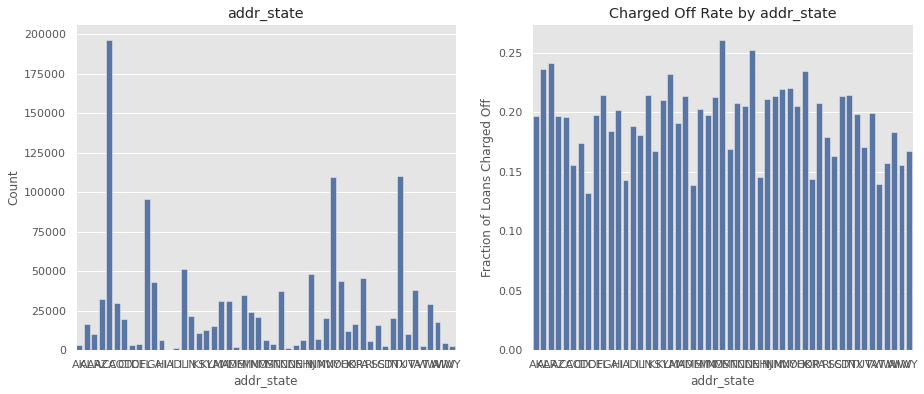

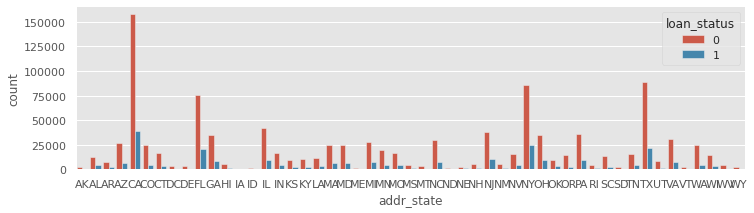

In [108]:
# we should keep this feature

plot_var('addr_state','addr_state', continuous=False)

In [109]:
# this is a date, we can remove the month part

data['earliest_cr_line'] = data['earliest_cr_line'].apply(lambda s: int(s[-4:]))

StatementMeta(Spark11, 7, 109, Finished, Available)

StatementMeta(Spark11, 7, 110, Finished, Available)

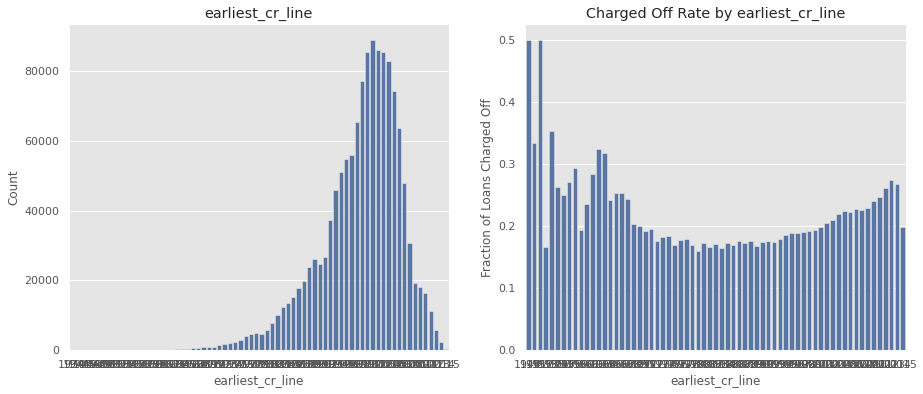

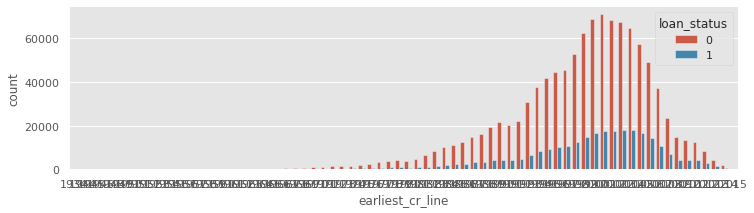

In [110]:
plot_var('earliest_cr_line', 'earliest_cr_line', continuous=False)

In [111]:
missing_values('earliest_cr_line')

StatementMeta(Spark11, 7, 111, Finished, Available)

'% of missing values = 0.0'

In [112]:
# this feature should be kept as well, charge-off rate varies from 16% - 50%

StatementMeta(Spark11, 7, 112, Finished, Available)

In [113]:
data['emp_length'].value_counts()

StatementMeta(Spark11, 7, 113, Finished, Available)

10+ years    442199
2 years      121743
< 1 year     108061
3 years      107597
1 year        88494
5 years       84154
4 years       80556
6 years       62733
8 years       60701
7 years       59624
9 years       50937
Name: emp_length, dtype: int64

In [114]:
missing_values('emp_length')

StatementMeta(Spark11, 7, 114, Finished, Available)

'% of missing values = 6.5'

StatementMeta(Spark11, 7, 115, Finished, Available)

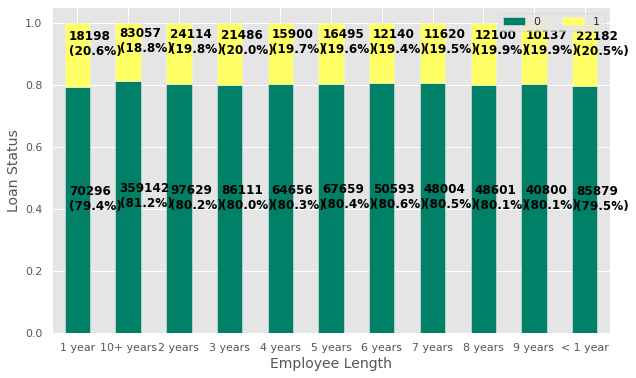

In [115]:
# employment length
# we see that the loan status is constant with the length of the employment, so we don't need this feature

stack_bar(data,'emp_length',"Employee Length")

In [117]:
# plot_var('emp_length', 'emp_length', continuous=False)

StatementMeta(Spark11, 7, 117, Finished, Available)

In [118]:
# we can keep this column for now

StatementMeta(Spark11, 7, 118, Finished, Available)

In [119]:
data['emp_title'].describe()

StatementMeta(Spark11, 7, 119, Finished, Available)

count     1259525
unique     378353
top       Teacher
freq        21268
Name: emp_title, dtype: object

In [120]:
missing_values('emp_title')

StatementMeta(Spark11, 7, 120, Finished, Available)

'% of missing values = 7.39'

In [121]:
# there are too many unique titles for this feature to be useful, so we drop this feature.

data['emp_title'].unique()
data.drop('emp_title', axis=1, inplace=True)

StatementMeta(Spark11, 7, 121, Finished, Available)

In [122]:
# sub_grade is a subset of grade


print(sorted(data['grade'].unique()))
print()
print(sorted(data['sub_grade'].unique()))

StatementMeta(Spark11, 7, 122, Finished, Available)

['A', 'B', 'C', 'D', 'E', 'F', 'G']

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


In [123]:
missing_values('grade')

StatementMeta(Spark11, 7, 123, Finished, Available)

'% of missing values = 0.0'

In [124]:
missing_values('sub_grade')

StatementMeta(Spark11, 7, 124, Finished, Available)

'% of missing values = 0.0'

StatementMeta(Spark11, 7, 125, Finished, Available)

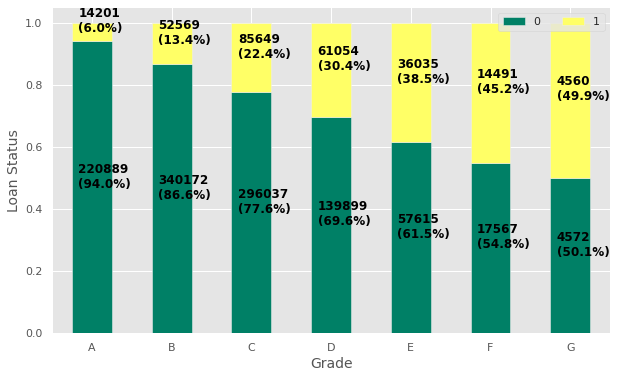

In [125]:
stack_bar(data,'grade',"Grade")

StatementMeta(Spark11, 7, 126, Finished, Available)

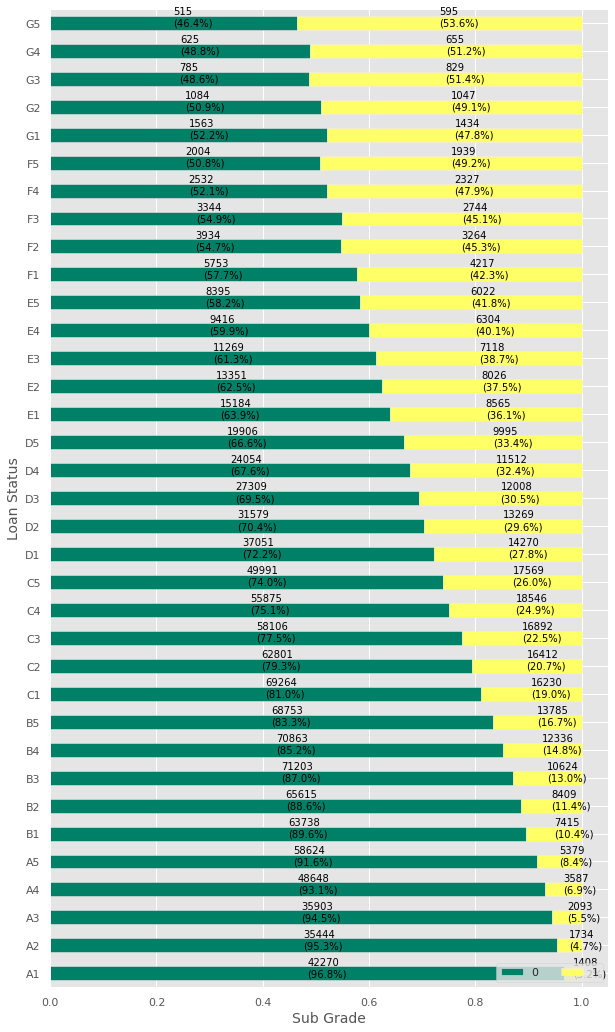

In [126]:
stack_bar_h(data,'sub_grade',"Sub Grade")

In [127]:
# looking at the graphs above, we can see that there is a strong connection between sub_grades and charging off
# also, there is a connection between grade and charging-off, but since sub_grade is a subset of grade and contains more values, we can remove grade

data.drop('grade', axis=1, inplace=True)

StatementMeta(Spark11, 7, 127, Finished, Available)

In [128]:
data['home_ownership'].value_counts()

StatementMeta(Spark11, 7, 128, Finished, Available)

MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

In [129]:
missing_values('home_ownership')

StatementMeta(Spark11, 7, 129, Finished, Available)

'% of missing values = 0.0'

In [130]:
# ANY and NONE can be moved to the OTHER categpry

data['home_ownership'] = data['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')
data['home_ownership'].value_counts()

StatementMeta(Spark11, 7, 130, Finished, Available)

MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: home_ownership, dtype: int64

StatementMeta(Spark11, 7, 131, Finished, Available)

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


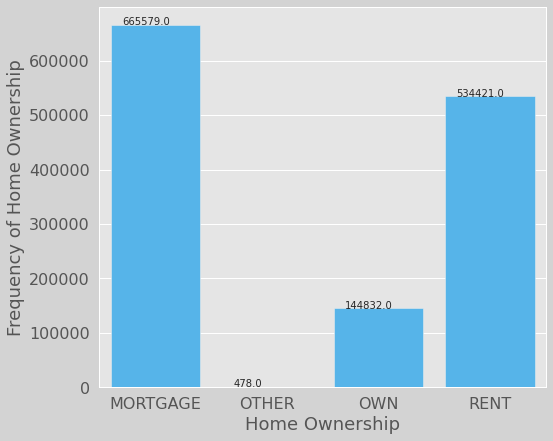

In [131]:
count_plot(data,'home_ownership','Home Ownership',width=8,height=7)

StatementMeta(Spark11, 7, 132, Finished, Available)

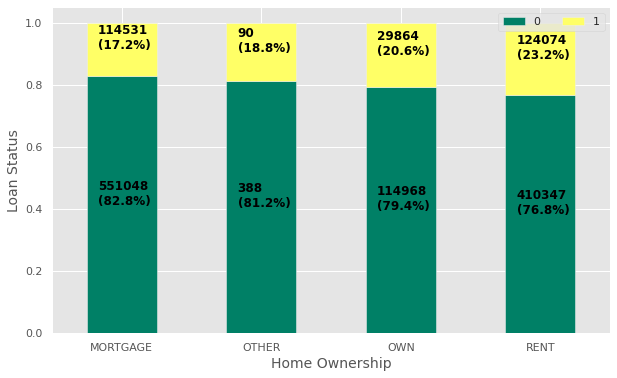

In [132]:
stack_bar(data,'home_ownership','Home Ownership')

In [133]:
# looking at the graphs, we can keep this feature since there is a difference in charge-off rate and it varies from 17.2% to 23.2%

StatementMeta(Spark11, 7, 133, Finished, Available)

In [134]:
data['application_type'].value_counts()

StatementMeta(Spark11, 7, 134, Finished, Available)

Individual    1319510
Joint App       25800
Name: application_type, dtype: int64

In [135]:
missing_values('application_type')

StatementMeta(Spark11, 7, 135, Finished, Available)

'% of missing values = 0.0'

StatementMeta(Spark11, 7, 136, Finished, Available)

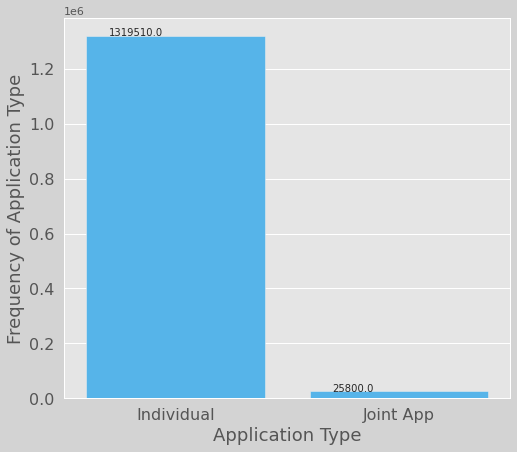

In [136]:
count_plot(data,'application_type','Application Type',width=8,height=7)

StatementMeta(Spark11, 7, 137, Finished, Available)

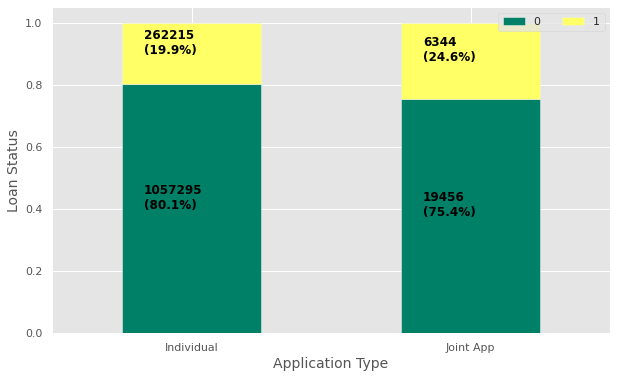

In [137]:
# we can keep this feature as well, because the charge-off rate varies from 19.9% - 24.6%

stack_bar(data,'application_type','Application Type')

In [138]:
# the majority of the loans are individual applications and they are more possible to be charged off than joint app.

StatementMeta(Spark11, 7, 138, Finished, Available)

In [139]:
data['initial_list_status'].value_counts()

StatementMeta(Spark11, 7, 139, Finished, Available)

w    784010
f    561300
Name: initial_list_status, dtype: int64

In [140]:
missing_values('initial_list_status')

StatementMeta(Spark11, 7, 140, Finished, Available)

'% of missing values = 0.0'

StatementMeta(Spark11, 7, 141, Finished, Available)

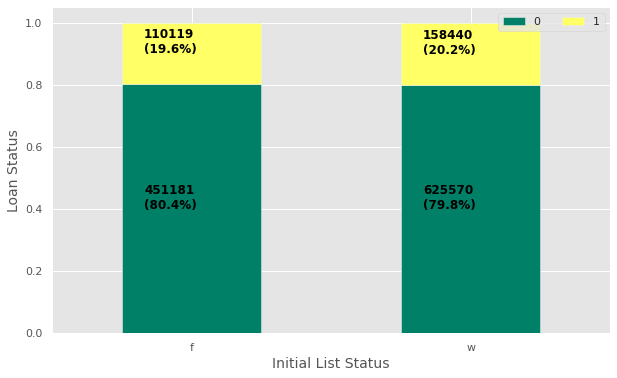

In [141]:
stack_bar(data,'initial_list_status','Initial List Status')

In [142]:
# there is a slight difference in the charge off rate between these two values
# might be good to drop this featre
data.drop('initial_list_status', axis=1, inplace=True)

StatementMeta(Spark11, 7, 142, Finished, Available)

In [143]:
data[['purpose', 'title']].head()

StatementMeta(Spark11, 7, 143, Finished, Available)

purpose               title
0  debt_consolidation  Debt consolidation
1      small_business            Business
2    home_improvement                 NaN
4      major_purchase      Major purchase
5  debt_consolidation  Debt consolidation

In [144]:
data['purpose'].value_counts()

StatementMeta(Spark11, 7, 144, Finished, Available)

debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving                  9480
vacation                9065
house                   7253
wedding                 2294
renewable_energy         933
educational              326
Name: purpose, dtype: int64

In [145]:
data['title'].value_counts()

StatementMeta(Spark11, 7, 145, Finished, Available)

Debt consolidation                                                                  660960
Credit card refinancing                                                             249910
Home improvement                                                                     75073
Other                                                                                66778
Major purchase                                                                       24045
Debt Consolidation                                                                   15695
Medical expenses                                                                     13576
Business                                                                             11750
Car financing                                                                        11220
Vacation                                                                              8046
Moving and relocation                                                                 7944

In [146]:
# these two features seem to contain similar data, except that the title contains much more information
# we can drop the title

data.drop('title',axis=1,inplace=True)

StatementMeta(Spark11, 7, 146, Finished, Available)

StatementMeta(Spark11, 7, 147, Finished, Available)

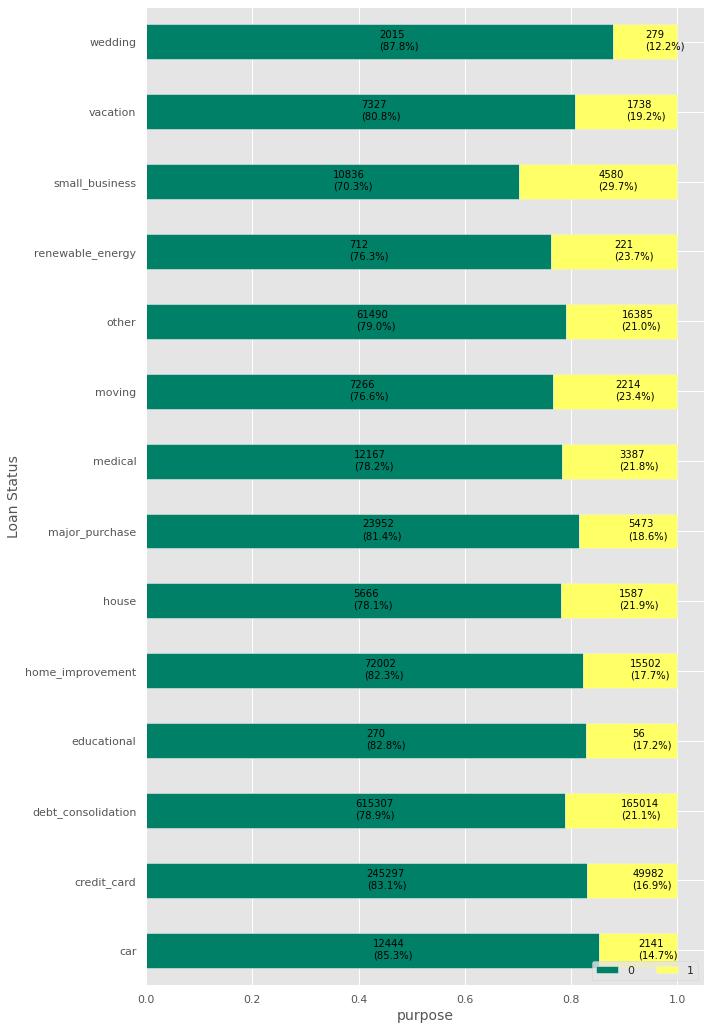

In [147]:
stack_bar_h(data,'purpose','purpose')

In [148]:
missing_values('purpose')

StatementMeta(Spark11, 7, 148, Finished, Available)

'% of missing values = 0.0'

In [149]:
data['term'].value_counts()

StatementMeta(Spark11, 7, 149, Finished, Available)

 36 months    1020743
 60 months     324567
Name: term, dtype: int64

In [150]:
missing_values('term')

StatementMeta(Spark11, 7, 150, Finished, Available)

'% of missing values = 0.0'

In [151]:
data['term'] = data['term'].apply(lambda x: int(x[0:3]))

StatementMeta(Spark11, 7, 151, Finished, Available)

StatementMeta(Spark11, 7, 152, Finished, Available)

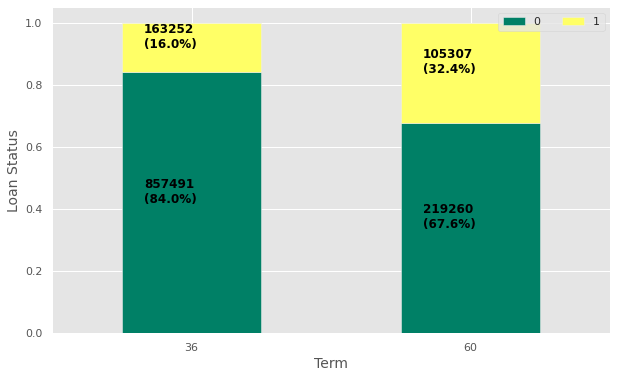

In [152]:
stack_bar(data,'term','Term')

In [153]:
# in comparison to 36-month loans, 60-month loans have a ~ 2x higher rate of charge-offs
# we should keep this feature

StatementMeta(Spark11, 7, 153, Finished, Available)

In [154]:
data['verification_status'].value_counts()

StatementMeta(Spark11, 7, 154, Finished, Available)

Source Verified    521273
Verified           418336
Not Verified       405701
Name: verification_status, dtype: int64

StatementMeta(Spark11, 7, 155, Finished, Available)

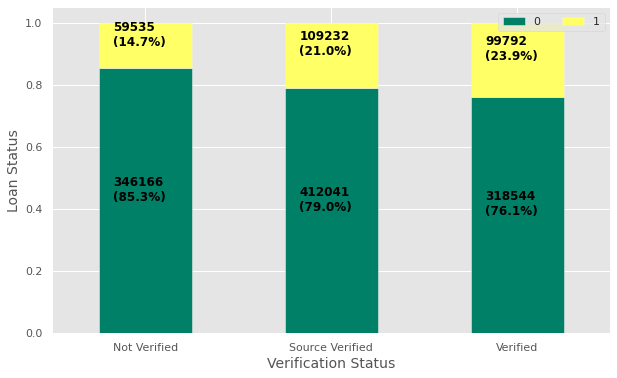

In [155]:
stack_bar(data,'verification_status','Verification Status')

In [156]:
missing_values('verification_status')

StatementMeta(Spark11, 7, 156, Finished, Available)

'% of missing values = 0.0'

In [157]:
# we should deffinately keep this feature, since there is a difference in the charge-off rate (14% - 23%)

StatementMeta(Spark11, 7, 157, Finished, Available)

StatementMeta(Spark11, 7, 158, Finished, Available)

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


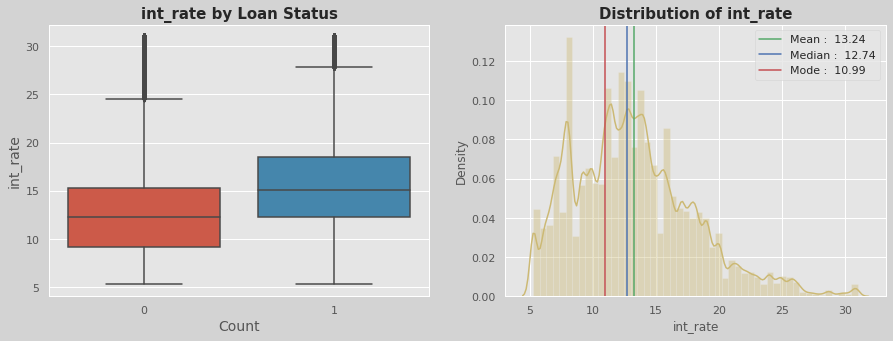

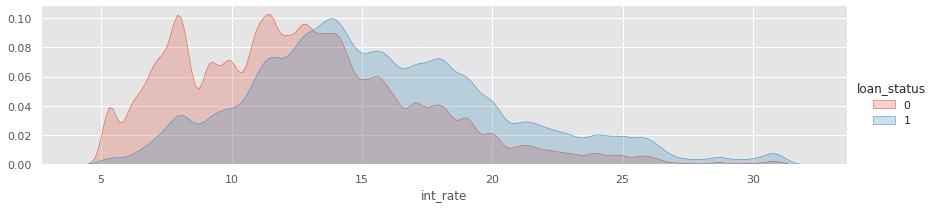

In [158]:
plot_numerical(data, 'int_rate', 'int_rate')

In [159]:
missing_values('int_rate')

StatementMeta(Spark11, 7, 159, Finished, Available)

'% of missing values = 0.0'

In [160]:
# charged-off loans tend to have higher median interest rates than the fully paid ones

data.groupby(['loan_status'])['int_rate'].describe()

StatementMeta(Spark11, 7, 160, Finished, Available)

count       mean       std   min    25%    50%    75%    max
loan_status                                                                  
0            1076751.0  12.623288  4.527227  5.31   9.17  12.23  15.31  30.99
1             268559.0  15.710714  4.910387  5.31  12.29  15.05  18.55  30.99

StatementMeta(Spark11, 7, 161, Finished, Available)

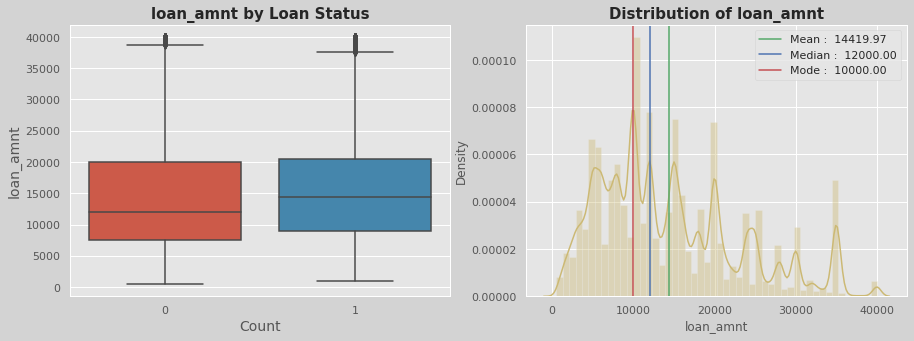

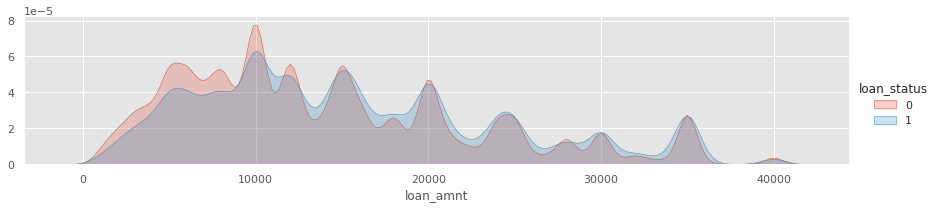

In [161]:
plot_numerical(data, 'loan_amnt', 'loan_amnt')

In [162]:
missing_values('loan_amnt')

StatementMeta(Spark11, 7, 162, Finished, Available)

'% of missing values = 0.0'

In [163]:
# charged-off loans tend to have higher median loan amounts than the fully paid ones

data.groupby(['loan_status'])['loan_amnt'].describe()

StatementMeta(Spark11, 7, 163, Finished, Available)

count          mean          std    min     25%      50%  \
loan_status                                                                 
0            1076751.0  14134.369808  8669.028973  500.0  7500.0  12000.0   
1             268559.0  15565.055444  8814.560077  900.0  9000.0  14350.0   

                 75%      max  
loan_status                    
0            20000.0  40000.0  
1            20400.0  40000.0

StatementMeta(Spark11, 7, 164, Finished, Available)

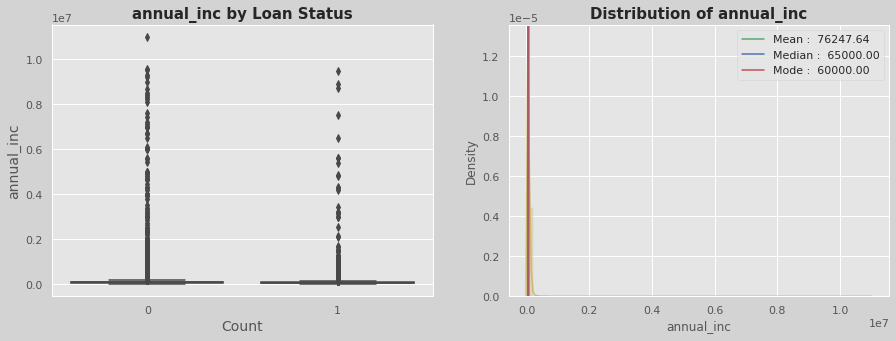

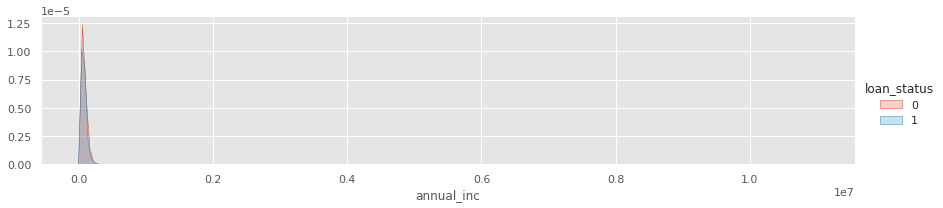

In [164]:
plot_numerical(data, 'annual_inc', 'annual_inc')

In [165]:
# not much can be concluded from the graph above, since the values range from $0 to $10999200
# we should scale this range

data['annual_inc_lg'] = data['annual_inc'].apply(lambda x: np.log10(x+1))

StatementMeta(Spark11, 7, 165, Finished, Available)

In [166]:
data['annual_inc_lg'].describe()

StatementMeta(Spark11, 7, 166, Finished, Available)

count    1.345310e+06
mean     4.812814e+00
std      2.477200e-01
min      0.000000e+00
25%      4.660685e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: annual_inc_lg, dtype: float64

StatementMeta(Spark11, 7, 167, Finished, Available)

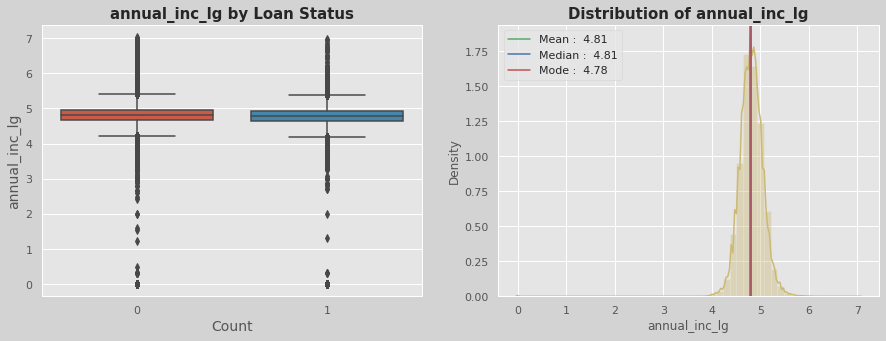

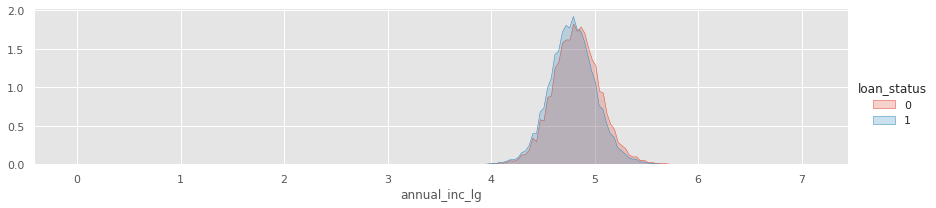

In [167]:
plot_numerical(data, 'annual_inc_lg', 'annual_inc_lg')

In [168]:
missing_values('annual_inc_lg')

StatementMeta(Spark11, 7, 168, Finished, Available)

'No missing values'

In [169]:
# there is a difference in the charge-off rate between people with higher income - people with higher annual income tend to pay off the loan

data.groupby(['loan_status'])['annual_inc_lg'].describe()

StatementMeta(Spark11, 7, 169, Finished, Available)

count      mean       std  min       25%       50%       75%  \
loan_status                                                                     
0            1076751.0  4.820560  0.248526  0.0  4.672107  4.812920  4.968488   
1             268559.0  4.781756  0.241984  0.0  4.633479  4.778158  4.929424   

                  max  
loan_status            
0            7.041361  
1            6.977724

StatementMeta(Spark11, 7, 170, Finished, Available)

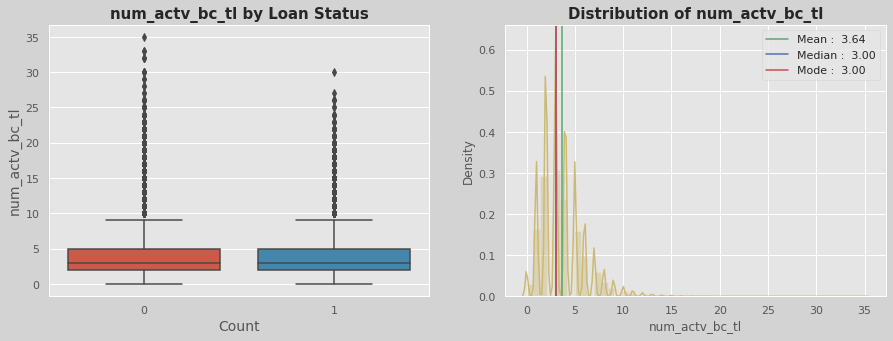

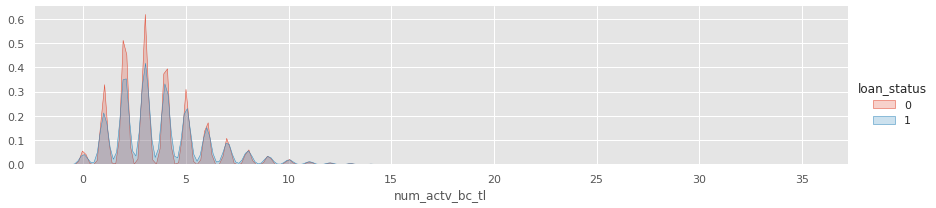

In [170]:
plot_numerical(data, 'num_actv_bc_tl', 'num_actv_bc_tl')

In [171]:
missing_values('num_actv_bc_tl')

StatementMeta(Spark11, 7, 171, Finished, Available)

'% of missing values = 3.11'

In [172]:
data['num_actv_bc_tl'].describe()

StatementMeta(Spark11, 7, 172, Finished, Available)

count    1.277783e+06
mean     3.642732e+00
std      2.248239e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      3.500000e+01
Name: num_actv_bc_tl, dtype: float64

In [173]:
data['num_actv_bc_tl'].value_counts().sort_index()

StatementMeta(Spark11, 7, 173, Finished, Available)

0.0      27343
1.0     146415
2.0     260750
3.0     273898
4.0     212435
5.0     141796
6.0      88124
7.0      51872
8.0      30482
9.0      18023
10.0     10636
11.0      6347
12.0      3778
13.0      2271
14.0      1276
15.0       850
16.0       489
17.0       367
18.0       219
19.0       149
20.0        75
21.0        52
22.0        43
23.0        26
24.0        22
25.0        13
26.0        14
27.0         3
28.0         2
29.0         2
30.0         5
32.0         3
33.0         2
35.0         1
Name: num_actv_bc_tl, dtype: int64

In [174]:
# we will take care of this later
# there are missing values, so let's fill them 
# data['num_actv_bc_tl'] = data['num_actv_bc_tl'].fillna(4)

StatementMeta(Spark11, 7, 174, Finished, Available)

In [175]:
# it is weird to think that someone has more than 10 accounts, so let's assume this info is not useful and drop those columns

data = data[data['num_actv_bc_tl'] < 10]

StatementMeta(Spark11, 7, 175, Finished, Available)

In [176]:
# here we see that the means of these two features are similar, but we should maybe drop this feature

data.groupby(['loan_status'])['num_actv_bc_tl'].describe()

StatementMeta(Spark11, 7, 176, Finished, Available)

count      mean       std  min  25%  50%  75%  max
loan_status                                                       
0            999800.0  3.438355  1.905967  0.0  2.0  3.0  5.0  9.0
1            251338.0  3.614945  1.981585  0.0  2.0  3.0  5.0  9.0

In [177]:
# data.drop('num_actv_bc_tl', axis=1, inplace=True)

StatementMeta(Spark11, 7, 177, Finished, Available)

StatementMeta(Spark11, 7, 178, Finished, Available)

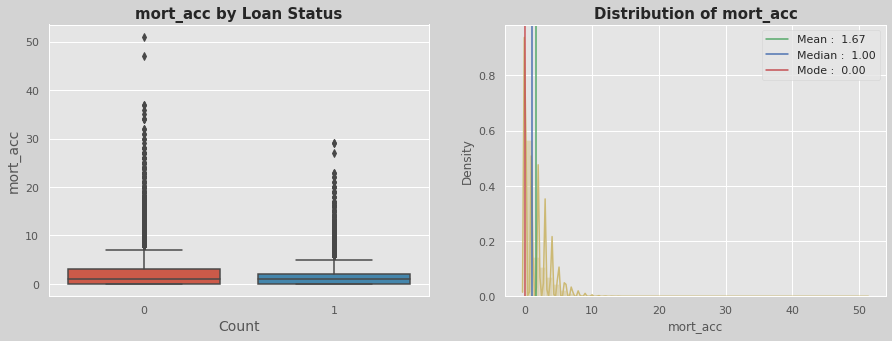

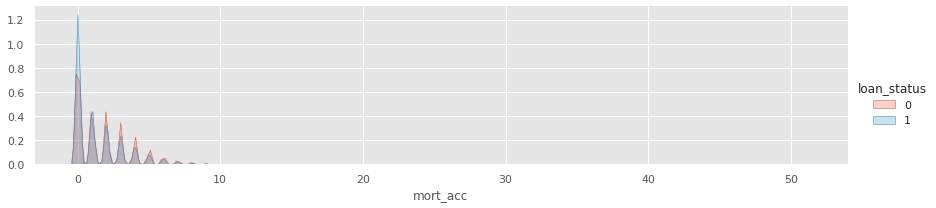

In [178]:
plot_numerical(data, 'mort_acc', 'mort_acc')

In [179]:
# we might need to add the missing values

missing_values('mort_acc')

StatementMeta(Spark11, 7, 179, Finished, Available)

'% of missing values = 2.21'

In [180]:
data['mort_acc'].describe()

StatementMeta(Spark11, 7, 180, Finished, Available)

count    1.251138e+06
mean     1.668914e+00
std      1.994944e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.100000e+01
Name: mort_acc, dtype: float64

In [181]:
# we will fill the missing values later
# data['mort_acc'] = data['mort_acc'].fillna(2)

StatementMeta(Spark11, 7, 181, Finished, Available)

In [182]:
data['mort_acc'].value_counts().sort_index()

StatementMeta(Spark11, 7, 182, Finished, Available)

0.0     503924
1.0     218710
2.0     182838
3.0     134629
4.0      91506
5.0      55333
6.0      31208
7.0      16101
8.0       7959
9.0       4060
10.0      2076
11.0      1148
12.0       614
13.0       332
14.0       236
15.0       126
16.0        91
17.0        60
18.0        43
19.0        27
20.0        22
21.0        14
22.0        13
23.0        10
24.0        15
25.0         9
26.0         5
27.0         7
28.0         4
29.0         3
30.0         2
31.0         2
32.0         2
34.0         3
35.0         1
36.0         1
37.0         2
47.0         1
51.0         1
Name: mort_acc, dtype: int64

In [183]:
data = data[data['mort_acc'] < 10]

StatementMeta(Spark11, 7, 183, Finished, Available)

In [184]:
data.groupby(['loan_status'])['mort_acc'].describe()

StatementMeta(Spark11, 7, 184, Finished, Available)

count      mean       std  min  25%  50%  75%  max
loan_status                                                       
0            995522.0  1.702154  1.917395  0.0  0.0  1.0  3.0  9.0
1            250746.0  1.342382  1.745183  0.0  0.0  1.0  2.0  9.0

StatementMeta(Spark11, 7, 185, Finished, Available)

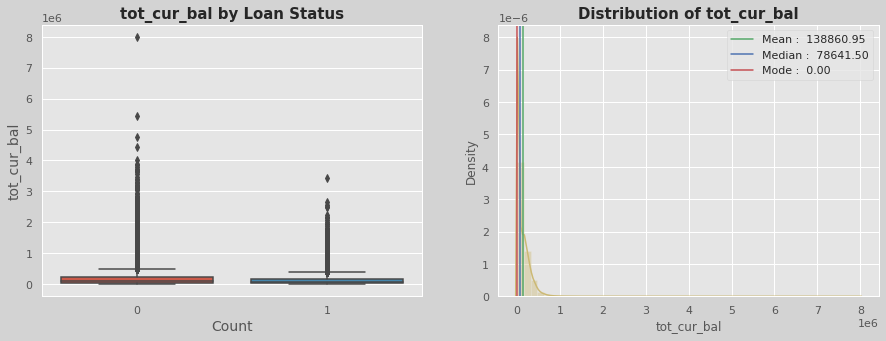

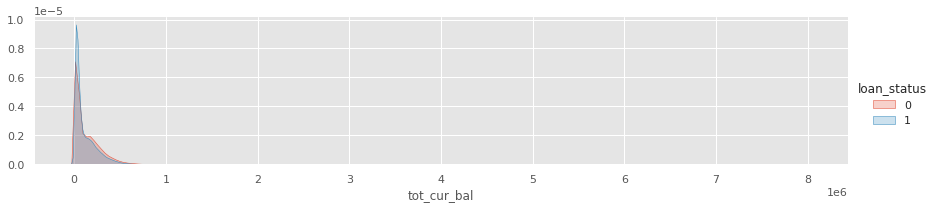

In [185]:
plot_numerical(data, 'tot_cur_bal', 'tot_cur_bal')

In [186]:
missing_values('tot_cur_bal')

StatementMeta(Spark11, 7, 186, Finished, Available)

'% of missing values = 3.11'

In [187]:
data['tot_cur_bal'].describe()

StatementMeta(Spark11, 7, 187, Finished, Available)

count    1.246268e+06
mean     1.388609e+05
std      1.540863e+05
min      0.000000e+00
25%      2.904500e+04
50%      7.864150e+04
75%      2.079122e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

In [188]:
# it is more difficult to fill in the missing values, so we can skip that 
#  we need to get a better representation of our data, and for that we can use log function

StatementMeta(Spark11, 7, 188, Finished, Available)

In [189]:
data['tot_cur_bal_lg'] = data['tot_cur_bal'].apply(lambda x: np.log10(x+1))
data.groupby(['loan_status'])['tot_cur_bal_lg'].describe()

StatementMeta(Spark11, 7, 189, Finished, Available)

count      mean       std  min       25%       50%       75%  \
loan_status                                                                    
0            995522.0  4.875843  0.564107  0.0  4.472142  4.932760  5.335208   
1            250746.0  4.794086  0.540122  0.0  4.432456  4.779762  5.237228   

                  max  
loan_status            
0            6.903094  
1            6.536215

StatementMeta(Spark11, 7, 190, Finished, Available)

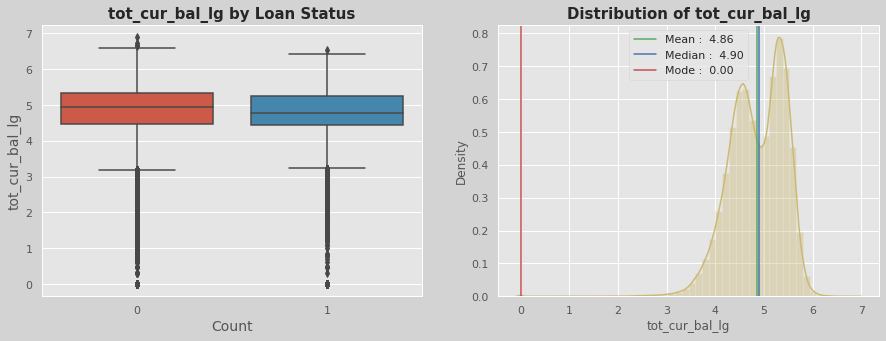

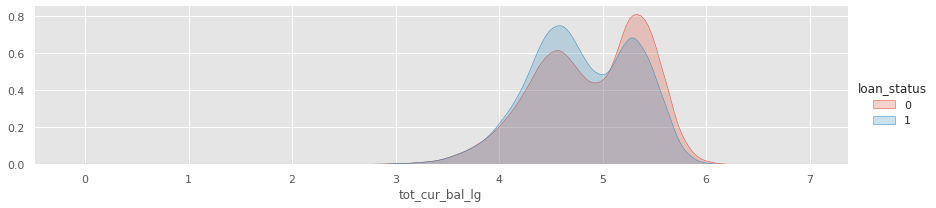

In [190]:
plot_numerical(data, 'tot_cur_bal_lg', 'tot_cur_bal_lg')

In [191]:
# we should keep this feature - from the above we see that this feature is more present in the case of the customers who fully paid the loan

StatementMeta(Spark11, 7, 191, Finished, Available)

StatementMeta(Spark11, 7, 192, Finished, Available)

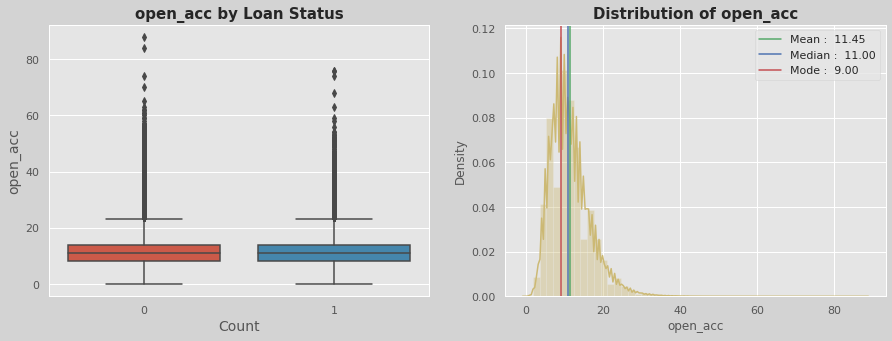

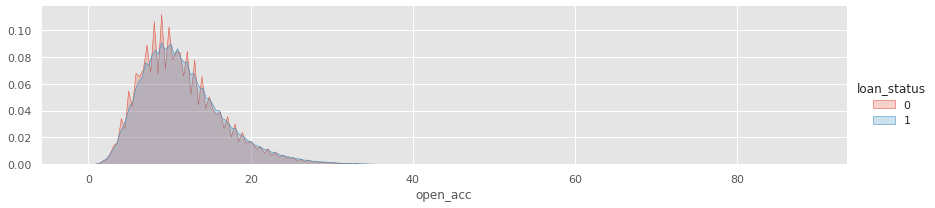

In [192]:
plot_numerical(data, 'open_acc', 'open_acc')

In [193]:
missing_values('open_acc')

StatementMeta(Spark11, 7, 193, Finished, Available)

'% of missing values = 0.0'

In [194]:
data.groupby(['loan_status'])['open_acc'].describe()

StatementMeta(Spark11, 7, 194, Finished, Available)

count       mean       std  min  25%   50%   75%   max
loan_status                                                           
0            995522.0  11.385078  5.184899  0.0  8.0  11.0  14.0  88.0
1            250746.0  11.684721  5.319148  0.0  8.0  11.0  14.0  76.0

In [195]:
# there seems no significant difference in number of credit lines between fully paid loans and charged-off loans
# we can drop this feature

data.drop('open_acc', axis=1, inplace=True)

StatementMeta(Spark11, 7, 195, Finished, Available)

StatementMeta(Spark11, 7, 196, Finished, Available)

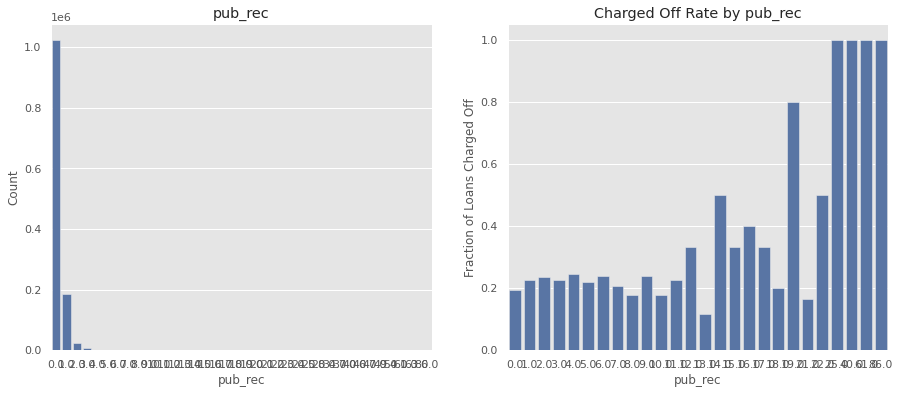

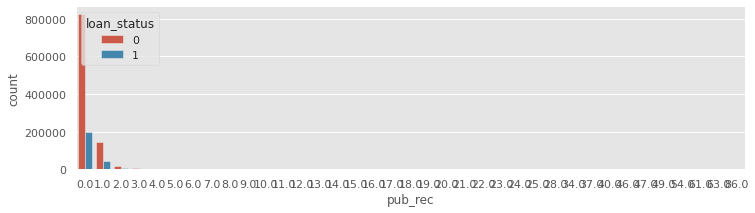

In [196]:
plot_var('pub_rec','pub_rec', continuous=False)

In [197]:
missing_values('pub_rec')

StatementMeta(Spark11, 7, 197, Finished, Available)

'% of missing values = 0.0'

In [198]:
data['pub_rec'].describe()

StatementMeta(Spark11, 7, 198, Finished, Available)

count    1.246268e+06
mean     2.257348e-01
std      6.132437e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.600000e+01
Name: pub_rec, dtype: float64

In [199]:
data['pub_rec'].value_counts()

StatementMeta(Spark11, 7, 199, Finished, Available)

0.0     1025091
1.0      184955
2.0       23879
3.0        7219
4.0        2561
5.0        1239
6.0         617
7.0         275
8.0         156
9.0          79
10.0         56
11.0         40
12.0         27
13.0         17
15.0          9
21.0          6
16.0          5
18.0          5
19.0          5
14.0          4
17.0          3
22.0          2
24.0          2
28.0          2
20.0          2
34.0          1
46.0          1
47.0          1
61.0          1
40.0          1
54.0          1
86.0          1
63.0          1
23.0          1
49.0          1
25.0          1
37.0          1
Name: pub_rec, dtype: int64

In [200]:
data.groupby(['loan_status'])['pub_rec'].describe()

StatementMeta(Spark11, 7, 200, Finished, Available)

count      mean       std  min  25%  50%  75%   max
loan_status                                                        
0            995522.0  0.218056  0.597951  0.0  0.0  0.0  0.0  63.0
1            250746.0  0.256219  0.669659  0.0  0.0  0.0  0.0  86.0

In [201]:
# pub_rec column > 11 have significant number of charged-off loans, and also it has low counts 

StatementMeta(Spark11, 7, 201, Finished, Available)

In [202]:
data.pub_rec = data.pub_rec.map(lambda x: 3 if x >2.0 else x)

StatementMeta(Spark11, 7, 202, Finished, Available)

StatementMeta(Spark11, 7, 203, Finished, Available)

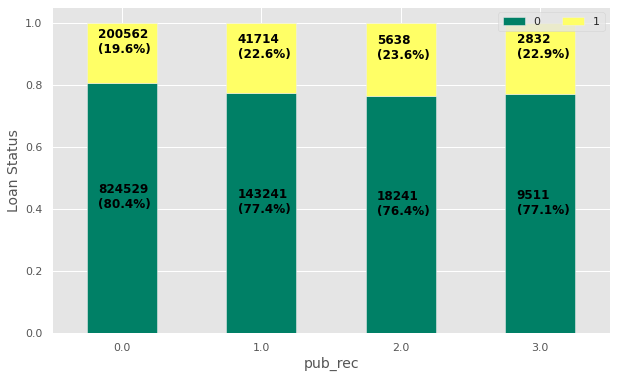

In [203]:
stack_bar(data, 'pub_rec', 'pub_rec')

In [204]:
data.groupby(['loan_status'])['pub_rec'].describe()

StatementMeta(Spark11, 7, 204, Finished, Available)

count      mean       std  min  25%  50%  75%  max
loan_status                                                       
0            995522.0  0.209193  0.509313  0.0  0.0  0.0  0.0  3.0
1            250746.0  0.245212  0.545729  0.0  0.0  0.0  0.0  3.0

In [205]:
# we should keep this feature

StatementMeta(Spark11, 7, 205, Finished, Available)

In [206]:
# these two features are correlated, so we can keep only one of them

data[['pub_rec','pub_rec_bankruptcies']].corr()

StatementMeta(Spark11, 7, 206, Finished, Available)

pub_rec  pub_rec_bankruptcies
pub_rec               1.00000               0.73522
pub_rec_bankruptcies  0.73522               1.00000

StatementMeta(Spark11, 7, 207, Finished, Available)

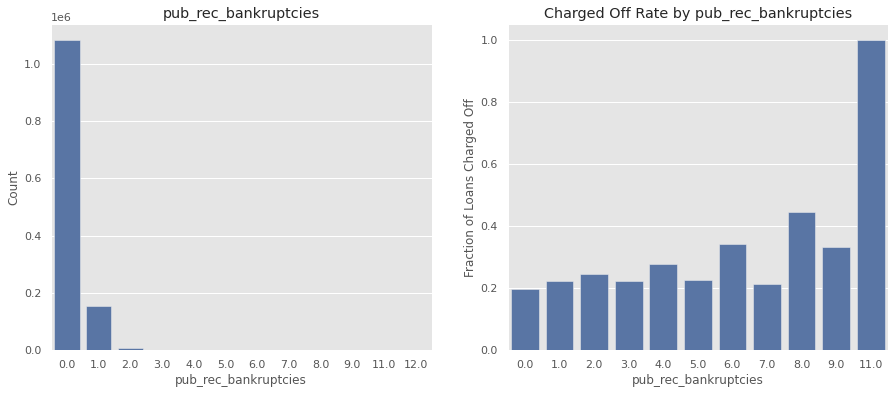

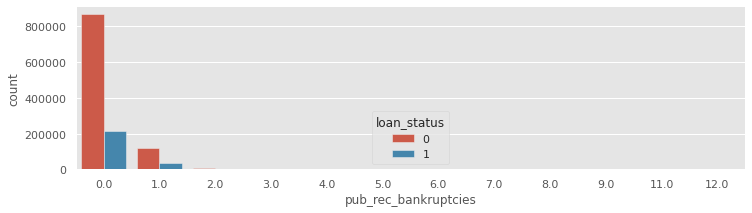

In [207]:
plot_var('pub_rec_bankruptcies','pub_rec_bankruptcies', continuous=False)

In [208]:
missing_values('pub_rec_bankruptcies')

StatementMeta(Spark11, 7, 208, Finished, Available)

'% of missing values = 0.06'

In [209]:
# let's drop pub_rec

data.drop('pub_rec_bankruptcies', axis=1, inplace=True)

StatementMeta(Spark11, 7, 209, Finished, Available)

StatementMeta(Spark11, 7, 210, Finished, Available)

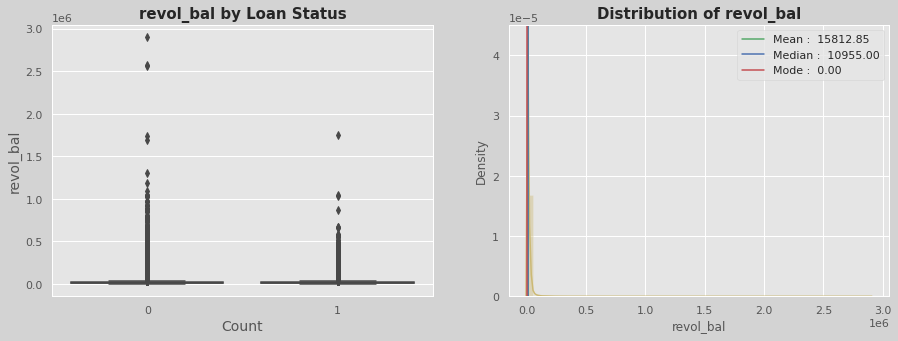

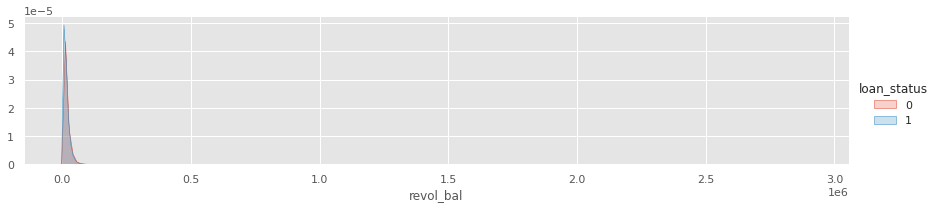

In [210]:
plot_numerical(data, 'revol_bal', 'revol_bal')

In [211]:
missing_values('revol_bal')

StatementMeta(Spark11, 7, 211, Finished, Available)

'% of missing values = 0.0'

In [212]:
data['revol_bal'].value_counts()

StatementMeta(Spark11, 7, 212, Finished, Available)

0.0          5361
5235.0        101
6312.0         99
4777.0         97
5453.0         97
6118.0         96
5249.0         93
5849.0         93
5891.0         93
7035.0         93
5451.0         93
5655.0         93
6780.0         92
5365.0         92
5399.0         91
8.0            91
3804.0         91
6868.0         91
4643.0         90
5853.0         90
5265.0         90
8851.0         90
5498.0         90
5886.0         90
5997.0         90
5729.0         90
5314.0         90
4784.0         90
5754.0         89
5487.0         89
6315.0         89
2.0            89
4543.0         89
4096.0         89
6462.0         89
6497.0         89
4986.0         88
4802.0         88
5296.0         88
6184.0         88
4459.0         88
5978.0         88
6406.0         88
5232.0         88
5389.0         87
5570.0         87
5839.0         87
6001.0         87
5956.0         87
7337.0         87
5723.0         87
4479.0         87
6239.0         87
5645.0         87
5181.0         87
4260.0    

In [213]:
data.groupby(['loan_status'])['revol_bal'].describe()

StatementMeta(Spark11, 7, 213, Finished, Available)

count          mean           std  min     25%      50%  \
loan_status                                                               
0            995522.0  16061.819661  22413.971763  0.0  5905.0  10989.0   
1            250746.0  14824.365430  18100.131253  0.0  5896.0  10815.0   

                 75%        max  
loan_status                      
0            19475.0  2904836.0  
1            18483.0  1746716.0

In [214]:
data['revol_bal_lg'] = data['revol_bal'].apply(lambda x:np.log10(x+1))

StatementMeta(Spark11, 7, 214, Finished, Available)

StatementMeta(Spark11, 7, 215, Finished, Available)

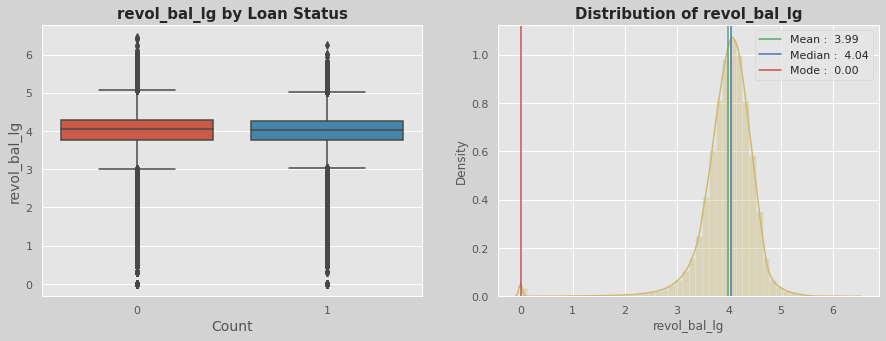

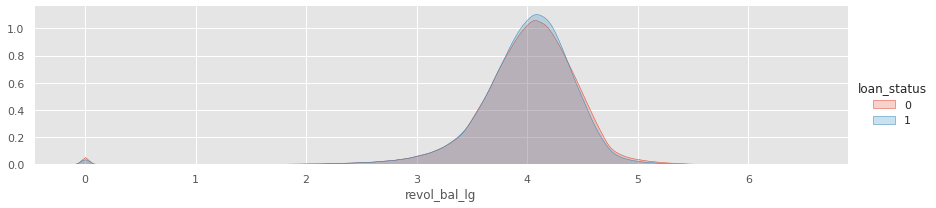

In [215]:
plot_numerical(data, 'revol_bal_lg', 'revol_bal_lg')

In [216]:
data.groupby(['loan_status'])['revol_bal_lg'].describe()

StatementMeta(Spark11, 7, 216, Finished, Available)

count      mean       std  min       25%       50%       75%  \
loan_status                                                                    
0            995522.0  3.990845  0.520321  0.0  3.771293  4.040998  4.289500   
1            250746.0  3.977306  0.502455  0.0  3.770631  4.034067  4.266796   

                  max  
loan_status            
0            6.463122  
1            6.242223

In [217]:
# there isn't big difference in the means, so we can drop this feature
data.drop(['revol_bal', 'revol_bal_lg'], axis=1, inplace=True)

StatementMeta(Spark11, 7, 217, Finished, Available)

StatementMeta(Spark11, 7, 218, Finished, Available)

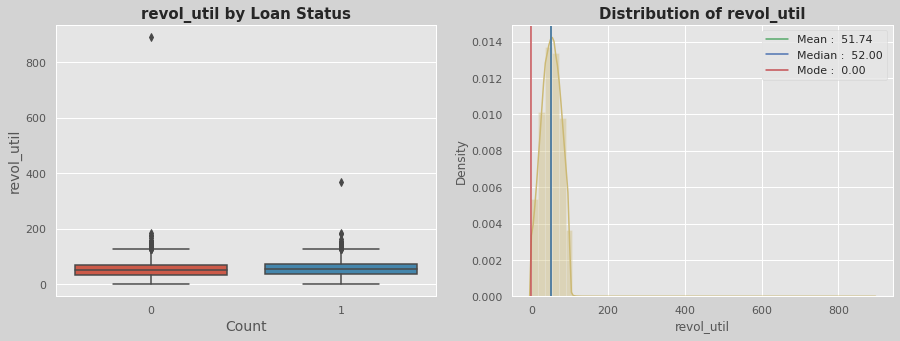

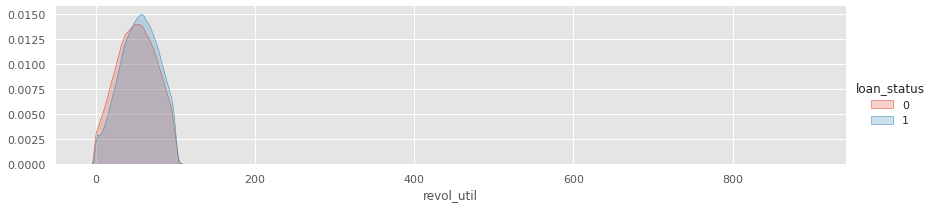

In [218]:
plot_numerical(data, 'revol_util', 'revol_util')

In [219]:
missing_values('revol_util')

StatementMeta(Spark11, 7, 219, Finished, Available)

'% of missing values = 0.08'

In [220]:
data.groupby(['loan_status'])['revol_util'].describe()

StatementMeta(Spark11, 7, 220, Finished, Available)

count       mean        std  min   25%   50%   75%    max
loan_status                                                              
0            994906.0  51.033782  24.501163  0.0  32.6  51.1  69.9  892.3
1            250592.0  54.559579  23.815621  0.0  37.2  55.2  72.8  366.6

In [221]:
# we can keep this feature since there is a difference in the mean values for the charged-off and fully paid loans

StatementMeta(Spark11, 7, 221, Finished, Available)

In [222]:
data['total_acc'].head()

StatementMeta(Spark11, 7, 222, Finished, Available)

0    13.0
1    38.0
2    18.0
4    35.0
5     6.0
Name: total_acc, dtype: float64

StatementMeta(Spark11, 7, 223, Finished, Available)

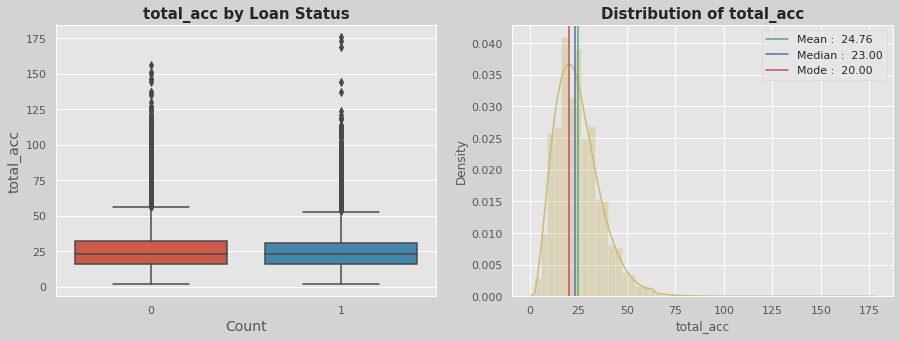

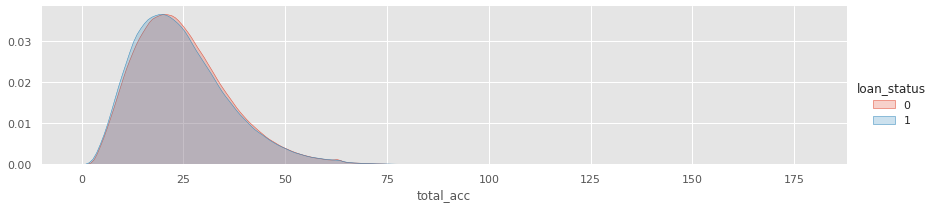

In [223]:
plot_numerical(data, 'total_acc', 'total_acc')

In [224]:
missing_values('total_acc')

StatementMeta(Spark11, 7, 224, Finished, Available)

'% of missing values = 0.0'

In [225]:
data.groupby(['loan_status'])['total_acc'].describe()

StatementMeta(Spark11, 7, 225, Finished, Available)

count       mean        std  min   25%   50%   75%    max
loan_status                                                              
0            995522.0  24.846303  11.751170  2.0  16.0  23.0  32.0  156.0
1            250746.0  24.423197  11.878037  2.0  16.0  23.0  31.0  176.0

In [226]:
# there is a small difference in the means, so we can keep this feature

StatementMeta(Spark11, 7, 226, Finished, Available)

In [227]:
# FICO scores: are a credit score: a number used by banks and credit cards to represent how credit-worthy a person is. 
# While there are a few types of credit scores used in the United States, the FICO score is the best known and most widely used.
# When a borrower applies for a loan, LendingClub gets the borrower’s credit score from FICO — 
# they are given a lower and upper limit of the range that the borrowers score belongs to, and they store those values as fico_range_low, fico_range_high. 
# After that, any updates to the borrowers score are recorded as last_fico_range_low, and last_fico_range_high.
# https://en.wikipedia.org/wiki/Credit_score_in_the_United_States#FICO_score

StatementMeta(Spark11, 7, 227, Finished, Available)

In [228]:
# these two features are correlated, so we can keep only one of them

data[['fico_range_low','fico_range_high']].corr()

StatementMeta(Spark11, 7, 228, Finished, Available)

fico_range_low  fico_range_high
fico_range_low              1.0              1.0
fico_range_high             1.0              1.0

StatementMeta(Spark11, 7, 229, Finished, Available)

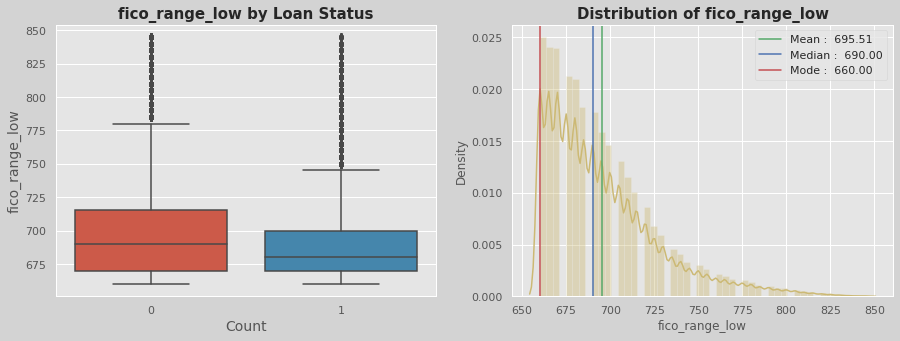

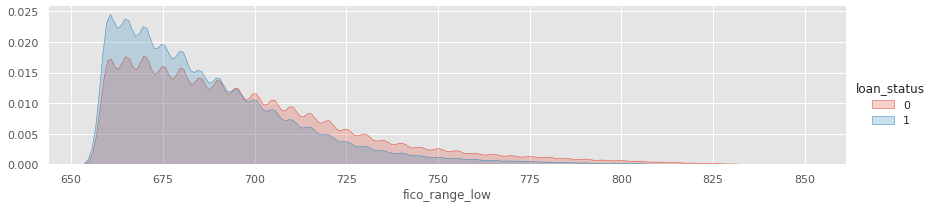

In [229]:
plot_numerical(data, 'fico_range_low', 'fico_range_low')

In [230]:
missing_values('fico_range_low')

StatementMeta(Spark11, 7, 230, Finished, Available)

'% of missing values = 0.0'

In [231]:
data.groupby(['loan_status'])['fico_range_low'].describe()

StatementMeta(Spark11, 7, 231, Finished, Available)

count        mean        std    min    25%    50%    75%  \
loan_status                                                                
0            995522.0  697.530682  32.557666  660.0  670.0  690.0  715.0   
1            250746.0  687.468075  25.719839  660.0  670.0  680.0  700.0   

               max  
loan_status         
0            845.0  
1            845.0

In [232]:
# same thing goes for the fico_range_high feature
# also, we see that the means for C-O and F-P vary

StatementMeta(Spark11, 7, 232, Finished, Available)

StatementMeta(Spark11, 7, 233, Finished, Available)

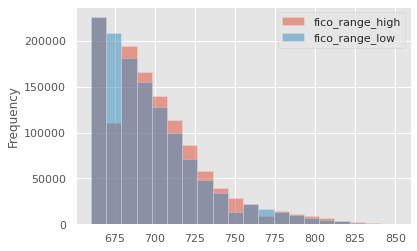

In [233]:
fico_columns = ['fico_range_high','fico_range_low']
data[fico_columns].plot.hist(alpha=0.5,bins=20)
plt.show()

In [234]:
# Both fico_range_high and fico_range_low have similar mean and standard deviation, so, we will use mean of both scores

data['fico'] = (data['fico_range_high'] + data['fico_range_low']) / 2
data = data.drop(['fico_range_high', 'fico_range_low'], axis=1)

StatementMeta(Spark11, 7, 234, Finished, Available)

StatementMeta(Spark11, 7, 235, Finished, Available)

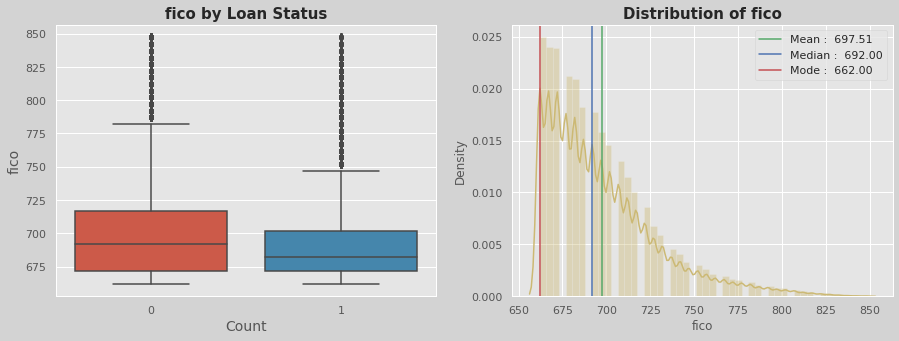

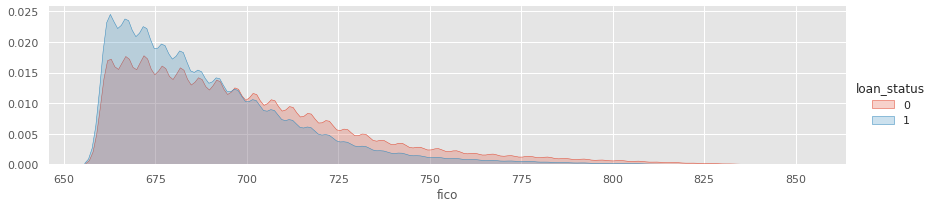

In [235]:
plot_numerical(data, 'fico', 'fico')

In [236]:
data.groupby(['loan_status'])['fico'].describe()

StatementMeta(Spark11, 7, 236, Finished, Available)

count        mean        std    min    25%    50%    75%  \
loan_status                                                                
0            995522.0  699.530767  32.558049  662.0  672.0  692.0  717.0   
1            250746.0  689.468103  25.720010  662.0  672.0  682.0  702.0   

               max  
loan_status         
0            847.5  
1            847.5

StatementMeta(Spark11, 7, 237, Finished, Available)

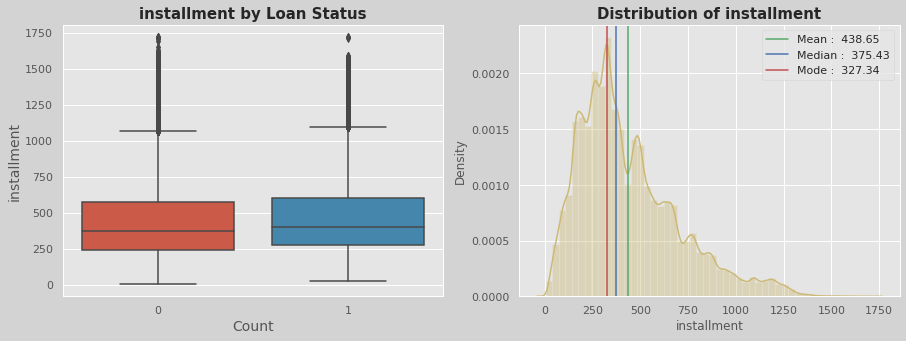

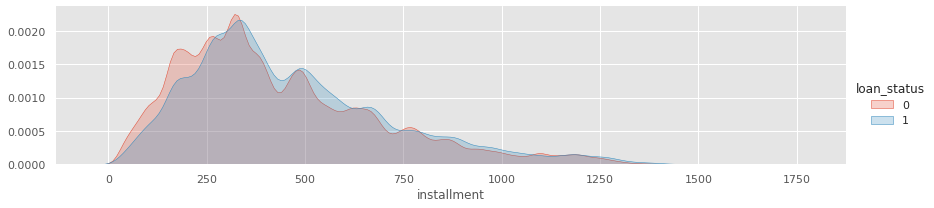

In [237]:
plot_numerical(data, 'installment', 'installment')

In [238]:
missing_values('installment')

StatementMeta(Spark11, 7, 238, Finished, Available)

'% of missing values = 0.0'

In [239]:
data.groupby(['loan_status'])['installment'].describe()

StatementMeta(Spark11, 7, 239, Finished, Available)

count        mean         std    min     25%      50%     75%  \
loan_status                                                                     
0            995522.0  432.056884  259.898899   4.93  243.23  368.930  573.66   
1            250746.0  464.838801  261.449070  27.85  276.06  402.405  603.01   

                 max  
loan_status           
0            1719.83  
1            1717.63

In [240]:
# charged-off loans tend to have higher installments, so we should keep this feature

StatementMeta(Spark11, 7, 240, Finished, Available)

In [241]:
data.shape

StatementMeta(Spark11, 7, 241, Finished, Available)

(1246268, 23)

In [242]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   print('number of outliers: '+ str(len(outliers)))
   print('max outlier value: '+ str(outliers.max()))
   print('min outlier value: '+ str(outliers.min()))

   return outliers

StatementMeta(Spark11, 7, 242, Finished, Available)

In [244]:
# let's save cleaned data to csv


data.to_csv('***/Cleaned_data.csv')  

StatementMeta(Spark11, 7, 244, Finished, Available)